## Car Pooling Algorithm




In [2]:
from pandas import reset_option
import matplotlib.pyplot as plt
import random
import requests
import copy

### Graph

In [3]:
class node:
    def __init__(self, id, type, flag, lat, long):
        self.id = id
        self.type = type # 0: car, 1: start, 2:end
        self.isAccessible = flag
        self.lat = lat
        self.long = long

In [4]:
class edge:
    def __init__(self, id, startNodeId, endNodeId, weight, polyLine, duration):
        self.id = id
        self.startNodeId = startNodeId # start point of an edge
        self.endNodeId = endNodeId # end point of an edge
        self.weight = weight # distance between two points
        self.polyLine = polyLine # google polyline encripted value for this path
        self.duration = duration

In [9]:
# Graph Class
class graph:
    def __init__(self):
        self.adjList = [[]] # list of edges
        self.nodes = [] # list of nodes
        self.nodeCounter = 0 # points to the next free node id
        self.edgeCounter = 0 # points to the next free edge id 
    
    def getNodeFromId(self, nodeId):
        for n in self.nodes:
            if n.id == nodeId:
                return n
    
    def getEdgeFromEdgeNodes(self, node1, node2):
        for e in self.adjList[node1]: # loops over all the edges related to the start node
            if e.endNodeId == node2: # if the edge is equal to the end node return it
                return e
        return -1 # -1 means there is no edge between the two entered nodes 
    
    def addNode(self, type, flag, lat, long):
        self.nodes.append(node(self.nodeCounter, type, flag, lat, long))
        self.nodeCounter += 1
        self.adjList.append([])
    
    def addEdge(self, startNode, endNode, weight, polyline, duration):
        self.adjList[startNode].append(edge(self.edgeCounter, startNode, endNode, weight, polyline, duration))
        self.edgeCounter += 1
    
    def calcEdgeWeight(self, startNode, endNode):
        s = self.getNodeFromId(startNode) # getting the start and end nodes 
        e = self.getNodeFromId(endNode)

        r = requests.get('http://127.0.0.1:5000/route/v1/driving/'+ str(s.long) +','+ str(s.lat) +';'+ str(e.long) +','+ str(e.lat) +'?steps=false') # makes a request using the pos of the start and end nodes
        data = r.json() # converts the json data to a readable format

        return data['routes'][0]['distance'], data['routes'][0]['geometry'], data['routes'][0]['duration'] # returns the distance to be used as the weight of an edge and the polyline
    
    def addCar(self, loc):
        self.addNode(0, False, loc[1], loc[0]) # car always has a type value of 0

        for node in self.nodes:
            if node.type == 1: # add a connection from the new car to all the starting nodes 
                w, l = self.calcEdgeWeight(self.nodeCounter-1, node.id)
                self.addEdge(self.nodeCounter-1, node.id, w, l)

    def addTrip(self, start, end):
        self.addNode(1, True, start[1], start[0]) # add the start node of a trip
        self.addNode(2, False, end[1], end[0]) # add the end node of a trip

        for node in self.nodes:
            if node.id != self.nodeCounter-1 and node.id != self.nodeCounter-2: # add an edge from every node to the new start and end nodes 
                w, l, d = self.calcEdgeWeight(node.id, self.nodeCounter-2)
                self.addEdge(node.id, self.nodeCounter-2, w, l, d)
                if node.type != 0: # if not a car
                    w, l, d = self.calcEdgeWeight(node.id, self.nodeCounter-1)
                    self.addEdge(node.id, self.nodeCounter-1, w, l, d) # add an edge from every node to the new end node (execpt form cars)

            if node.type != 0 and node.id != self.nodeCounter-2: # add an edge from the new start node to all the other start and end nodes
                w, l, d = self.calcEdgeWeight(self.nodeCounter-2, node.id)
                self.addEdge(self.nodeCounter-2, node.id, w, l, d)

            if node.type != 0 and node.id != self.nodeCounter-1 and node.id != self.nodeCounter-2: # add an edge from the new end node to all the other end and start nodes
                w, l, d = self.calcEdgeWeight(self.nodeCounter-1, node.id)
                self.addEdge(self.nodeCounter-1, node.id, w, l, d)
    
    # Functions for testing 

    def printAdjList(self):
        for x in range(0, len(self.adjList)):
            print(x, ": ", end =" ")
            for y in self.adjList[x]:
                print(y.endNodeId, end =" ")
            print("")

### OSRM

In [10]:
pickupNetwork = graph()
# enter coords as long, lat
pickupNetwork.addCar([14.513809277460041, 35.89897453256716]) # valletta

pickupNetwork.addTrip([14.423235598020154, 35.91419450996914], [14.407218690503381, 35.888194056331706]) # Mosta to imdina
pickupNetwork.addTrip([14.49291350433241, 35.87369410066685], [14.513809277460041, 35.89897453256716]) # Marsa to Valletta
pickupNetwork.addTrip([14.349747452527506, 35.952589620545496], [14.488425821564382, 35.88613649037252])  # Mellieha to Hamrun


### Tabu Search

In [14]:
def fitnessFunc(solution, graph):
    value = 0
    for n in range(1, len(solution)):
        n1 = solution[n]
        n2 = solution[n-1]
        value += graph.getEdgeFromEdgeNodes(n2, n1).weight # adds up the weight of all the edges in the path
    
    return value

creating a random solution 

In [15]:
def initSolution(graph): # used to randomly generate an solution 
    solution = []
    visited = [False] * len(graph.nodes) # will indicate if a node has been visited yet

    for n in graph.nodes:
        if n.type == 0: # finds a car as the starting point
            solution.append(n.id)
            visited[n.id] = True
    
    while(visited.count(visited[0]) != len(visited)): # while the values in the visited list are not all equal
        avalabile = False 
        n = random.choice(graph.adjList[solution[-1]]).endNodeId # picks a random node that can be reached form the current last node in the solution
        if graph.getNodeFromId(n).type == 2: # if the node picked is a end point 
            start = n -1
            for x in solution: # check if its start point is already in the list 
                if x == start:
                    avalabile = True # if yes we can add the point to the solution 
                    break
        else:
            avalabile = True

        if visited[n] == False and avalabile: # add the point to the solution 
            visited[n] = True
            solution.append(n)

    return solution

neighborhood function

In [16]:
def neighborhood(solution, graph): # returns all the possible swaps for a given solution 
    neighborhood = []

    for x in range(1, len(solution)):
        for y in range(x + 1, len(solution)):
            newSolution = solution.copy()
            newSolution[x], newSolution[y] = newSolution[y], newSolution[x] # swap 2 values 
            if checkSolution(newSolution, graph) == True: # check if swap is valid
                neighborhood.append(newSolution) # if swap is good add it to the list 
    
    return neighborhood


In [17]:
def checkSolution(solution, graph):
    correct = True
    # loop over the whole solution and check if it is possible to get from one node to the next. If it is solution is valid
    for n in range(1, len(solution)): 
        n1 = solution[n]
        n2 = solution[n-1]
        edge = graph.getEdgeFromEdgeNodes(n2, n1) # returns -1 if there is no edge

        if edge == -1:
            return False # the solution is not valid 

        if graph.getNodeFromId(n1).type == 2: # if the point is an end point 
            start = n1 -1
            for x in solution[:n]: # check if its start point is in the list before it
                if x == start:
                    correct = True
                    break
                else:
                    correct = False

        if not correct:
            return False

    return True


### Tabu Search

In [11]:
def tabuSearch(graph, iterations, tabuSize, s):
    bestSolution = s
    solution = bestSolution
    tabuList = list()
    bestCost = fitnessFunc(bestSolution, graph)
    counter = 1

    while counter <= iterations:
        neighbours = neighborhood(solution, graph)
        found = False # indicates we found a set of different nodes that are not in the tabu list 
        currentBestSolutionIndex = 0
        currentBestSolution = neighbours[currentBestSolutionIndex]

        while not found and currentBestSolutionIndex < len(neighbours) - 1:
            i = 0
            while i < len(currentBestSolution):
                if currentBestSolution[i] != solution[i]: # if the same node position is not equal 
                    firstNode = currentBestSolution[i]
                    secondNode = solution[i]
                    break
                i = i + 1

            if [firstNode, secondNode] not in tabuList and [secondNode, firstNode] not in tabuList: # check if the swap is in the tabu list or not 
                tabuList.append([firstNode, secondNode]) # add the set to the tabuList
                found = True 

                solution = currentBestSolution
                cost = fitnessFunc(currentBestSolution, graph)

                if cost < bestCost: # checks if the new solution is better than the current best 
                    bestCost = cost
                    bestSolution = solution
            
            else:
                currentBestSolutionIndex += 1 # if nothing was found in with the current swap, go the the next one 
                currentBestSolution = neighbours[currentBestSolutionIndex]
        
        if len(tabuList) >= tabuSize:
            tabuList.pop(0) # removes the oldest element in the list

        counter = counter + 1
    
    return bestSolution, bestCost



In [12]:
s = initSolution(pickupNetwork)

In [13]:
print(s)

[0, 5, 1, 2, 6, 3, 4]


In [14]:
bestSolution, bestCost = tabuSearch(pickupNetwork, 500000, 7, s)

KeyboardInterrupt: 

In [ ]:
print("Start solution: ", s, " Cost: ", fitnessFunc(s, pickupNetwork))
print("End solution: ", bestSolution, " Cost: ", bestCost)

Start solution:  [0, 3, 1, 2, 4, 5, 6]  Cost:  70807.1
End solution:  [0, 3, 1, 5, 2, 6, 4]  Cost:  51375.899999999994


### using multiple cars

In [7]:
pickupNetwork2 = graph()
# enter coords as long, lat
pickupNetwork2.addCar([14.513809277460041, 35.89897453256716]) # valletta
pickupNetwork2.addCar([14.513809277460041, 35.89897453256716]) # valletta
pickupNetwork2.addCar([14.513809277460041, 35.89897453256716]) # valletta

pickupNetwork2.addTrip([14.423235598020154, 35.91419450996914], [14.407218690503381, 35.888194056331706]) # Mosta to mdina
pickupNetwork2.addTrip([14.49291350433241, 35.87369410066685], [14.513809277460041, 35.89897453256716]) # Marsa to Valletta
pickupNetwork2.addTrip([14.349747452527506, 35.952589620545496], [14.488425821564382, 35.88613649037252])  # Mellieha to Hamrun



pickupNetwork2.addTrip([14.396021566820055, 35.93589926856759], [14.407218690503381, 35.888194056331706]) # st pauls bay to mdina
pickupNetwork2.addTrip([14.513809277460041, 35.89897453256716], [14.396021566820055, 35.93589926856759]) # Valletta to st pauls bay
pickupNetwork2.addTrip([14.469391291395608,35.87691014067125], [14.488425821564382, 35.88613649037252])  # qormi to Hamrun


pickupNetwork2.addTrip([14.432798599308622, 35.846482945229674], [14.480448112126183, 35.8215269171298]) # siggiewi to zurrieq
pickupNetwork2.addTrip([14.480448112126183, 35.8215269171298], [14.432798599308622, 35.846482945229674]) # zurrieq to siggiewi
pickupNetwork2.addTrip([14.349747452527506, 35.952589620545496], [14.510671636760655, 35.88200443585789])  # Mellieha to paola

# pickupNetwork2.addTrip([14.423235598020154, 35.91419450996914], [14.407218690503381, 35.888194056331706])
# pickupNetwork2.addTrip([14.49291350433241, 35.87369410066685], [14.513809277460041, 35.89897453256716])
# pickupNetwork2.addTrip([14.49291350433241, 35.87369410066685], [14.513809277460041, 35.89897453256716])




In [8]:
carSize = 3
def initSolution2(graph): # used to randomly generate a solution 
    solutions = []
    visited = [False] * len(graph.nodes) # will indicate if a node has been visited yet
    
    nodePointer = 0


    for n in graph.nodes:
        solution = []
        if n.type == 0: # finds a car as the starting point
            solution.append(n.id)
            visited[n.id] = True
            s = 0
            while s < carSize and s < (len(graph.nodes)/2)-1:
                if graph.getNodeFromId(nodePointer).type != 0:
                    solution.append(nodePointer)
                    solution.append(nodePointer + 1)

                    nodePointer += 2
                    s += 1
                else:
                    nodePointer += 1

            solutions.append(solution)

    return solutions

In [9]:
def initSolution3(graph): # used to randomly generate a solution 
    numOfCars = 0
    for x in graph.nodes:
        if x.type == 0:
            numOfCars += 1
    numTrips = (len(graph.nodes)-numOfCars)/2
    
    solutions = []
    visited = [False] * len(graph.nodes) # will indicate if a node has been visited yet
    
    nodePointer = 0


    for n in graph.nodes:
        solution = []
        if n.type == 0: # finds a car as the starting point
            solution.append(n.id)
            visited[n.id] = True
            s = 0
            while s < carSize and s < (len(graph.nodes)/2)-1:
                if graph.getNodeFromId(nodePointer).type != 0:
                    solution.append(nodePointer)
                    solution.append(nodePointer + 1)

                    nodePointer += 2
                    s += 1
                else:
                    nodePointer += 1

            solutions.append(solution)

    return solutions

In [10]:
solutions = initSolution2(pickupNetwork2)

print(solutions)


[[0, 3, 4, 5, 6, 7, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]]


In [11]:
def neighborhood2(solutions, graph): # returns all the possible swaps for a given solution 
    neighborhood = []
    neighborhood2 = []

    for s in range(len(solutions)):
        for x in range(1, len(solutions[s])):
            for y in range(x + 1, len(solutions[s])):
                newSolution = copy.deepcopy(solutions)
                newSolution[s][x], newSolution[s][y] = newSolution[s][y], newSolution[s][x] # swap 2 values 
                if checkSolution(newSolution[s], graph) == True: # check if swap is valid
                    neighborhood.append(newSolution) # if swap is good add it to the list 
        
    for s in range(len(solutions)):
        for pos in range(1, len(solutions[s])):
            if graph.getNodeFromId(solutions[s][pos]).type == 1:
                start = pos
                end = solutions[s].index(graph.getNodeFromId(solutions[s][pos]+1).id)

                for sol in range(s+1, len(solutions)):
                    for index in range(1, len(solutions[s])):
                        if graph.getNodeFromId(solutions[sol][index]).type == 1:
                            newSolution = copy.deepcopy(solutions)
                            temp1, temp2 = newSolution[s][start], newSolution[s][end]
                            newSolution[s][start], newSolution[s][end] = newSolution[sol][index], newSolution[sol][solutions[sol].index(graph.getNodeFromId(solutions[sol][index]+1).id)]
                            newSolution[sol][index], newSolution[sol][solutions[sol].index(graph.getNodeFromId(solutions[sol][index]+1).id)] = temp1, temp2
                            neighborhood2.append(newSolution)


    
    return neighborhood, neighborhood2

In [12]:
def fitnessFunc2(solutions, graph):
    value = 0
    for solution in solutions:
        for n in range(1, len(solution)):
            n1 = solution[n]
            n2 = solution[n-1]
            value += graph.getEdgeFromEdgeNodes(n2, n1).weight # adds up the weight of all the edges in the path
    
    return value

In [13]:
swapPos, swapCars = neighborhood2(solutions, pickupNetwork2)

print(swapPos)
print("\n")
print(swapCars)

[[[0, 3, 5, 4, 6, 7, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 3, 7, 5, 6, 4, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 3, 4, 5, 7, 6, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 3, 4, 5, 6, 7, 8], [1, 9, 11, 10, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 3, 4, 5, 6, 7, 8], [1, 9, 13, 11, 12, 10, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 3, 4, 5, 6, 7, 8], [1, 9, 10, 11, 13, 12, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 3, 4, 5, 6, 7, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 17, 16, 18, 19, 20]], [[0, 3, 4, 5, 6, 7, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 19, 17, 18, 16, 20]], [[0, 3, 4, 5, 6, 7, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 16, 17, 19, 18, 20]]]


[[[0, 9, 10, 5, 6, 7, 8], [1, 3, 4, 11, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 11, 12, 5, 6, 7, 8], [1, 9, 10, 3, 4, 13, 14], [2, 15, 16, 17, 18, 19, 20]], [[0, 13, 14, 5, 6, 7, 8], [1, 9, 10, 11, 12, 3, 4], [2, 15, 16, 17, 18, 19, 20]], [[0, 15, 16,

In [14]:
def tabuSearch2(graph, iterations, tabuSize, s):
    counts = []
    bestSolution = s
    solution = bestSolution
    tabuList = list()
    tabuList2 = list()
    bestCost = fitnessFunc2(bestSolution, graph)
    counter = 1

    while counter <= iterations:
        neighbours, neighbours2 = neighborhood2(solution, graph)
        # print(neighbours)
        found = False # indicates we found a set of different nodes that are not in the tabu list 
        currentBestSolutionIndex = 0
        currentBestSolution = neighbours[currentBestSolutionIndex]

        while not found and currentBestSolutionIndex < len(neighbours) - 1:
            i = 0
            breaks = False
            while i < len(currentBestSolution):
                j = 0
                while j < len(currentBestSolution[i]):
                    if currentBestSolution[i][j] != solution[i][j]: # if the same node position is not equal 
                        firstNode = currentBestSolution[i][j]
                        secondNode = solution[i][j]
                        breaks = True
                        break
                    j += 1
                    if breaks:
                        break
                i += 1

            if [firstNode, secondNode] not in tabuList and [secondNode, firstNode] not in tabuList: # check if the swap is in the tabu list or not 
                tabuList.append([firstNode, secondNode]) # add the set to the tabuList
                found = True 

                solution = currentBestSolution
                cost = fitnessFunc2(currentBestSolution, graph)

                if cost < bestCost: # checks if the new solution is better than the current best 
                    bestCost = cost
                    bestSolution = solution
            
            else:
                currentBestSolutionIndex += 1 # if nothing was found in with the current swap, go the the next one 
                currentBestSolution = neighbours[currentBestSolutionIndex]
        
        if len(tabuList) >= tabuSize:
            tabuList.pop(0) # removes the oldest element in the list

        counter = counter + 1

        if len(neighbours2) > 0:
            found = False
            size = 0
            nextSoluiton = neighbours2[size]

            while not found and size < len(neighbours2) - 1:
                i = 0
                breaks = False
                while i < len(nextSoluiton): 
                    j = 0
                    pointsFound = 0
                    while j < len(nextSoluiton[i]):
                        if nextSoluiton[i][j] != solution[i][j]:
                            if pointsFound == 0:
                                start1 = nextSoluiton[i][j]
                                start2 = solution[i][j]
                                pointsFound += 1
                            else:
                                end1 = nextSoluiton[i][j]
                                end2 = solution[i][j]
                                breaks = True
                                break
                        j += 1
                    if breaks == True:
                        break
                    i += 1

                if [[start1, end1], [start2, end2]] not in tabuList2 and [[start2, end2], [start1, end1]] not in tabuList2:
                    tabuList2.append([[start1, end1], [start2, end2]])
                    found = True 

                    solution = nextSoluiton
                    cost = fitnessFunc2(solution, graph)

                    if cost < bestCost: # checks if the new solution is better than the current best 
                        bestCost = cost
                        bestSolution = solution
                else:
                    size += 1 # if nothing was found in with the current swap, go the the next one 
                    nextSoluiton = neighbours2[size]

                if len(tabuList2) >= tabuSize:
                    tabuList2.pop(0) # removes the oldest element in the list
        counts.append(bestCost)
    
    return bestSolution, bestCost, counts

In [23]:
bestSolution, bestCost, counts = tabuSearch2(pickupNetwork2, 100000, 30, solutions)
print("Start solution: ", solutions, " Cost: ", fitnessFunc2(solutions, pickupNetwork2))
print("End solution: ", bestSolution, " Cost: ", bestCost)

Start solution:  [[0, 3, 4, 5, 6, 7, 8], [1, 9, 10, 11, 12, 13, 14], [2, 15, 16, 17, 18, 19, 20]]  Cost:  204083.90000000002
End solution:  [[0, 13, 7, 19, 20, 14, 8], [1, 11, 12, 9, 10, 3, 4], [2, 5, 6, 15, 16, 17, 18]]  Cost:  120763.9


#### Graphing

In [17]:
def costOverTime(costs, iterations):
    eps = []
    for x in range(1, iterations+1):
        eps.append(x)

    plt.plot(eps, costs)
    plt.ylim(0, max(costs)+10000)

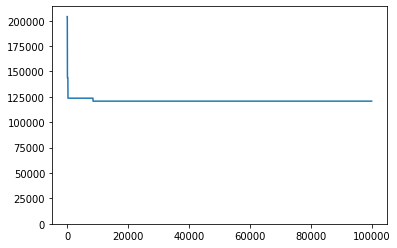

In [25]:
costOverTime(counts, 100000)

### Genetic Algorithm 

In [53]:
class geneticAlgorithm:
    def __init__(self, graph, ps):
        self.graph = graph
        self.populationSize = ps
        self.population = []
        self.fitness = []
        self.normFitness = [999] * ps

        self.initPopulation()
        self.normalizeFitness()
    
    def initPopulation(self):
        for x in range(self.populationSize):
            self.population.append(initSolution(self.graph))
            self.fitness.append(fitnessFunc(self.population[x], self.graph))
    
    def normalizeFitness(self):
        total = 0
        for i in range(self.populationSize):
            total += self.fitness[i]

        for i in range(self.populationSize):
            self.normFitness[i] = self.fitness[i]/total
    
    def pickSolution(self):
        index = 0
        r = random.uniform(0, 1)

        while r > 0:
            r = r - self.normFitness[index]
            index += 1
        
        return self.population[index-1]
    
    def swap(self, solution):
        swapped = False
        while not swapped:
            n1 = random.randint(1, len(self.graph.nodes)-1)
            n2 = random.randint(1, len(self.graph.nodes)-1)
            newSolution = solution.copy()
            newSolution[n1], newSolution[n2] = newSolution[n2], newSolution[n1]
            swapped = checkSolution(newSolution, self.graph)

        return newSolution
    
    def mutateSolution(self, solution, mutationFactor):
        newSolution = self.swap(solution)
        return newSolution
    
    def findBestSolution(self):
        bestSolution = self.population[0]
        bestCost = self.fitness[0]
        for i in range(1, self.populationSize):
            if self.fitness[i] < bestCost:
                bestCost = self.fitness[i]
                bestSolution = self.population[i]
        
        return bestSolution, bestCost
        
    
    def geneticAlgorithm(self, iterations):
        bestSolution, bestCost = self.findBestSolution()
        for iter in range(iterations):
            newPopultion = []
            newFitness = []
            for s in range(self.populationSize):
                newPopultion.append(self.mutateSolution(self.pickSolution(), 1))
                newFitness.append(fitnessFunc(newPopultion[s], self.graph))
            self.population = newPopultion
            self.fitness = newFitness
            self.normalizeFitness()

            popBestSolution, popBestCost = self.findBestSolution()
            if popBestCost < bestCost:
                bestSolution = popBestSolution
                bestCost = popBestCost
        
        return bestSolution, bestCost

In [58]:
g = geneticAlgorithm(pickupNetwork, 100)

s, c = g.geneticAlgorithm(1000)

print("End solution: ", s, " Cost: ", c)

End solution:  [0, 1, 5, 2, 3, 6, 4]  Cost:  50414.899999999994


### testing area 

In [ ]:

r = requests.get('http://127.0.0.1:5000/route/v1/driving/14.423235598020154,35.91419450996914;14.407218690503381,35.888194056331706?steps=false')

data = r.json()

print(data)

{'code': 'Ok', 'routes': [{'geometry': 'ioezE__`wAi@jEj@rGwKfMe@fC`ClG`XlLtCtChFfL~UxMjFbAbCwAxOpCn[eG`O]pQxC`Ce@bBrBtMxE', 'legs': [{'steps': [], 'distance': 4153.7, 'duration': 312.7, 'summary': '', 'weight': 312.7}], 'distance': 4153.7, 'duration': 312.7, 'weight_name': 'routability', 'weight': 312.7}], 'waypoints': [{'hint': 'SegAgGHoAIAAAAAAbAAAAAAAAAAfAAAAAAAAAN0ClkIAAAAA7aepQQAAAABsAAAAAAAAAB8AAAAgAAAAABTcADQCJALEFNwA0wEkAgAAfxFEWslf', 'distance': 20.706096, 'name': 'Triq Sir Arthur Borton', 'location': [14.42304, 35.914292]}, {'hint': '7MIAgAzDAIAcAAAAXAAAAO0AAAB3AAAASikZQo_98UJuL51DgQkeQxwAAABcAAAA7QAAAHcAAAAgAAAAY9fbAPWbIwIz1tsAQpwjAgYAHwFEWslf', 'distance': 28.75223, 'name': 'Triq tal-Infetti', 'location': [14.407523, 35.888117]}]}


In [ ]:
print(data['routes'][0]['distance'])
print(data['routes'][0]['geometry'])

4153.7
ioezE__`wAi@jEj@rGwKfMe@fC`ClG`XlLtCtChFfL~UxMjFbAbCwAxOpCn[eG`O]pQxC`Ce@bBrBtMxE
